In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set the directory for corn (maize) images
train_dir = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'

In [5]:
# List of disease classes
disease_classes = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [6]:
# Function to read images from a directory
def read_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            images.append(img)
    return images

In [7]:
# Function to resize images
def resize_images(images, target_size=(299, 299)):  # InceptionV3 input size
    resized_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (assuming BGR input)
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

In [8]:
# Read images from each class directory
blight_dir = os.path.join(train_dir, 'Blight')
common_rust_dir = os.path.join(train_dir, 'Common_Rust')
gray_leaf_spot_dir = os.path.join(train_dir, 'Gray_Leaf_Spot')
healthy_dir = os.path.join(train_dir, 'Healthy')

In [9]:
blight_images = read_images_from_dir(blight_dir)
common_rust_images = read_images_from_dir(common_rust_dir)
gray_leaf_spot_images = read_images_from_dir(gray_leaf_spot_dir)
healthy_images = read_images_from_dir(healthy_dir)

In [10]:
# Print the number of images in each class
print("Number of Blight images:", len(blight_images))
print("Number of Common Rust images:", len(common_rust_images))
print("Number of Gray Leaf Spot images:", len(gray_leaf_spot_images))
print("Number of Healthy images:", len(healthy_images))

Number of Blight images: 1146
Number of Common Rust images: 1306
Number of Gray Leaf Spot images: 574
Number of Healthy images: 1162


In [11]:
# Number of images in each class
classes = disease_classes
counts = [len(blight_images), len(common_rust_images), len(gray_leaf_spot_images), len(healthy_images)]

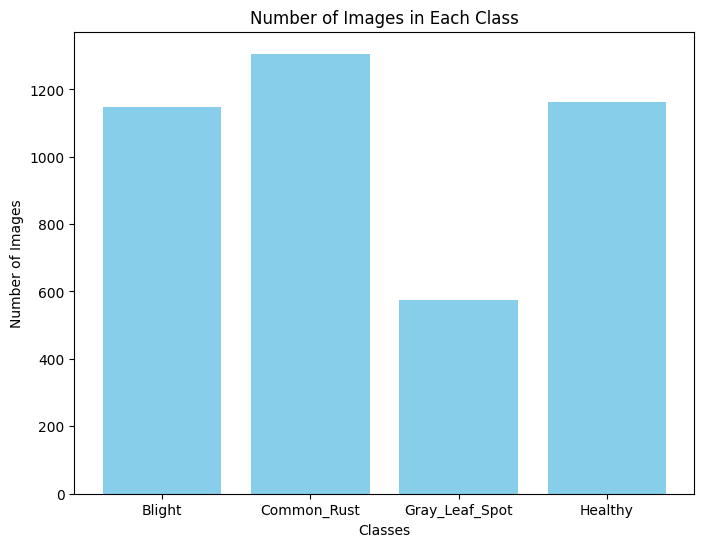

In [12]:
# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [13]:
# Resize images for each class
target_size = (299, 299)  # InceptionV3 input size
resized_blight = resize_images(blight_images, target_size)
resized_common_rust = resize_images(common_rust_images, target_size)
resized_gray_leaf_spot = resize_images(gray_leaf_spot_images, target_size)
resized_healthy = resize_images(healthy_images, target_size)


In [14]:
# Normalize images for each class
def normalize_images(images):
    return images.astype('float32') / 255.0

In [15]:
# Normalize images
normalized_blight = normalize_images(resized_blight)
normalized_common_rust = normalize_images(resized_common_rust)
normalized_gray_leaf_spot = normalize_images(resized_gray_leaf_spot)
normalized_healthy = normalize_images(resized_healthy)

In [16]:
# Concatenate images and labels
X = np.concatenate((normalized_blight, normalized_common_rust, normalized_gray_leaf_spot, normalized_healthy), axis=0)
y = np.array([0]*len(normalized_blight) + [1]*len(normalized_common_rust) + [2]*len(normalized_gray_leaf_spot) + [3]*len(normalized_healthy))

In [17]:
# Shuffle X and y in unison
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
# Load InceptionV3 model pre-trained on ImageNet without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(disease_classes), activation='softmax')(x)  # number of classes

In [22]:
# Combine the base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 47:43 30s/step - accuracy: 0.2500 - loss: 1.6904

I0000 00:00:1709584987.973234     165 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709584988.019895     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6078 - loss: 0.9769

W0000 00:00:1709585011.035237     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709585018.085983     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 473ms/step - accuracy: 0.6090 - loss: 0.9742 - val_accuracy: 0.8597 - val_loss: 0.3791
Epoch 2/20


W0000 00:00:1709585032.586297     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8415 - loss: 0.4058 - val_accuracy: 0.8806 - val_loss: 0.3097
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9007 - loss: 0.2981 - val_accuracy: 0.8925 - val_loss: 0.2786
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.8970 - loss: 0.2570 - val_accuracy: 0.8985 - val_loss: 0.2580
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9102 - loss: 0.2450 - val_accuracy: 0.9015 - val_loss: 0.2488
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9183 - loss: 0.2257 - val_accuracy: 0.9134 - val_loss: 0.2344
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9368 - loss: 0.1800 - val_accuracy: 0.9104 - val_loss: 0.2332
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9304 - loss: 0.1885 - val_accuracy: 0.9194 - val_loss: 0.2296
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9372 - loss: 0.1795 - val_accuracy: 0.895

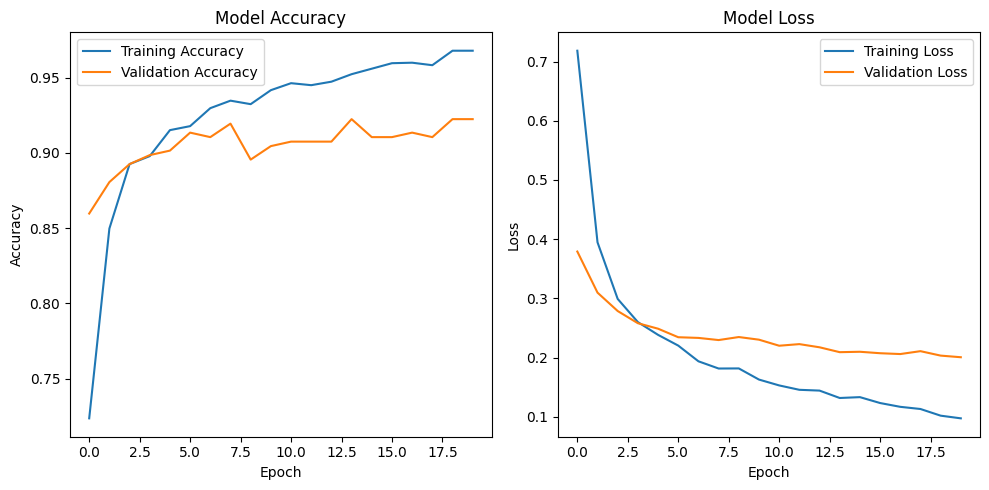

In [26]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model on test data
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.922434389591217


W0000 00:00:1709585329.329236     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
# Predict labels
y_pred = np.argmax(model.predict(X_test), axis=-1)
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=-1)

 2/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step

W0000 00:00:1709585341.931226     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step


W0000 00:00:1709585350.122264     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [29]:
# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9218579171336269
Recall: 0.9224343675417661
F1-score: 0.9217030454271035


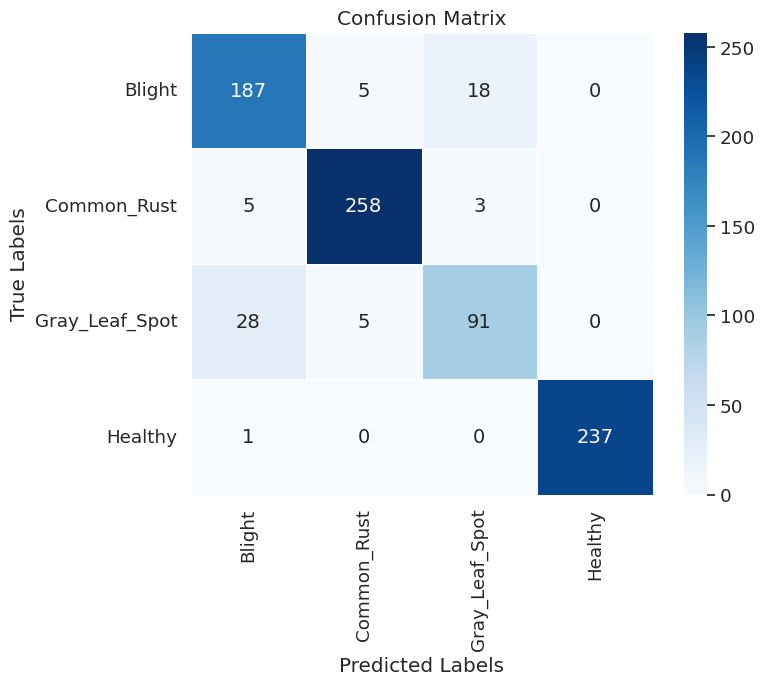

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=disease_classes, yticklabels=disease_classes, linewidths=.5, annot_kws={"size": 14})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('Corn-Model.h5')

# Define the class labels
class_names = {
    0: 'Blight',
    1: 'Common Rust',
    2: 'Gray Leaf Spot',
    3: 'Healthy'
}

# Define a function to predict the label of an uploaded image
def predict_uploaded_image(model, image_file):
    # Load and preprocess the image
    img = cv2.imread(image_file)
    if img is None:
        return "Invalid Image", None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (299, 299))  # Resize to match model's expected sizing
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img)
    
    # Get the predicted class
    class_idx = np.argmax(predictions)
    
    if class_idx >= len(class_names):
        return "Invalid Image", None
    
    # Get the predicted class label
    predicted_class = class_names[class_idx]
    
    # Get the confidence score
    confidence = predictions[0][class_idx]
    
    return predicted_class, confidence

# Path to the image you want to predict
image_path = '/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight/00c5c908-fc25-4710-a109-db143da23112___RS_Erly.B 7778.JPG'

# Predict the image
predicted_class, confidence = predict_uploaded_image(model, image_path)

# Print the result
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: Blight
Confidence: 0.92582726


In [34]:
# Save the model
model.save('Corn-Model.h5')  # Saves the model to a HDF5 file